## Prepare Notebook

In [93]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.ndimage import gaussian_filter
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [94]:
data_df = pd.read_csv("../data/ktr_data.csv", index_col=0, parse_dates=["date"])

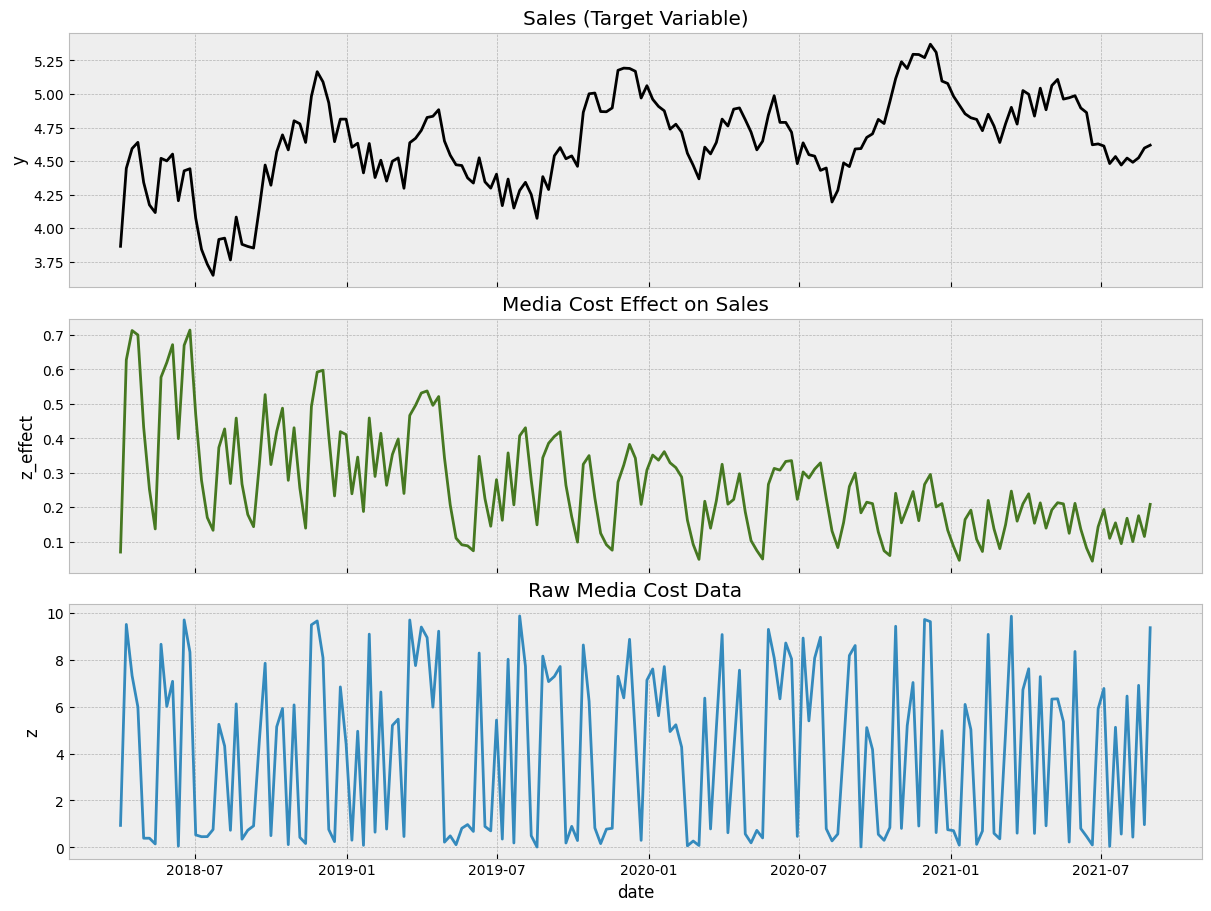

In [95]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained"
)
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=ax[0])
ax[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, ax=ax[1])
ax[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z", data=data_df, ax=ax[2])
ax[2].set(title="Raw Media Cost Data");

## Features

In [96]:
data_df.columns

columns_to_keep = ["date", "year", "month", "dayofyear", "z", "y"]

df = data_df[columns_to_keep].copy()

https://docs.pymc.io/en/stable/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html

- Trend

In [97]:
t = (df.index - df.index.min()) / (df.index.max() - df.index.min())
t = t.values

- Seasonality

In [98]:
n_order = 10
periods = df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

In [99]:
date = df["date"].values
y = df["y"].values
z = df["z"].values

## Models

### Base Model

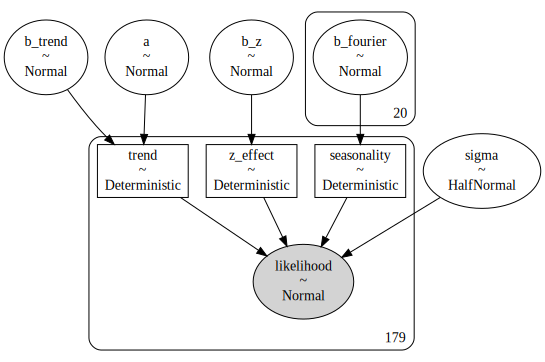

In [100]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as base_model:
    # priors
    ## intercept
    a = pm.Normal("a", mu=0, sigma=0.5)
    ## trend
    b_trend = pm.Normal("b_trend", mu=0, sigma=0.5)
    ## seasonality
    b_fourier = pm.Normal("b_fourier", mu=0, sigma=1, dims="fourier_features")
    ## regressor
    b_z = pm.Normal("b_z", mu=0, sigma=2)
    # model parametrization
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T)
    )
    trend = pm.Deterministic("trend", a + b_trend * t)
    z_effect = pm.Deterministic("z_effect", b_z * z)
    mu = trend  + seasonality  + z_effect
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    # likelihood
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)

    base_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz( base_model)

In [101]:
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement"""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

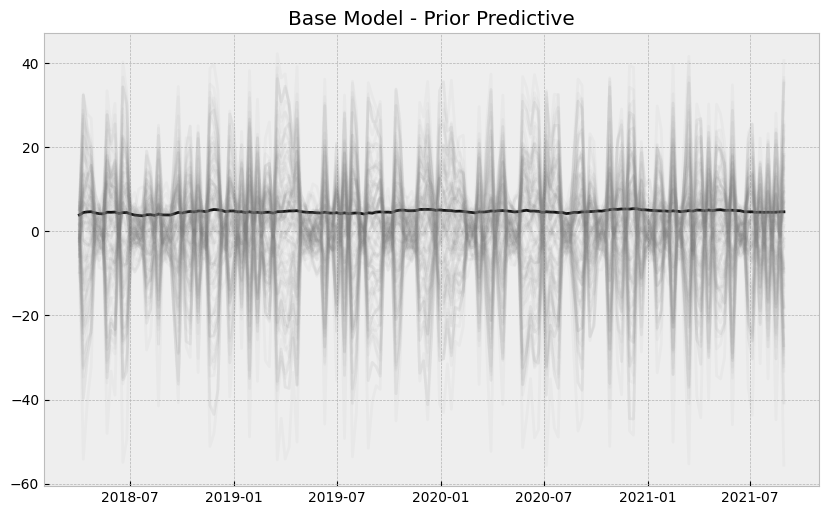

In [102]:
fig, ax = plt.subplots()
sns.lineplot(x=date, y=y, color="black", ax=ax)
ax.plot(
    date,
    _sample(array=base_model_prior_predictive["likelihood"], n_samples=100).T,
    color="gray",
    alpha=0.05,
)
ax.set(title="Base Model - Prior Predictive");

In [103]:
with base_model:
    base_model_trace = pm.sample(
        draws=1000, chains=4, return_inferencedata=True
    )
    base_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=base_model_trace
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_z, b_fourier, b_trend, a]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


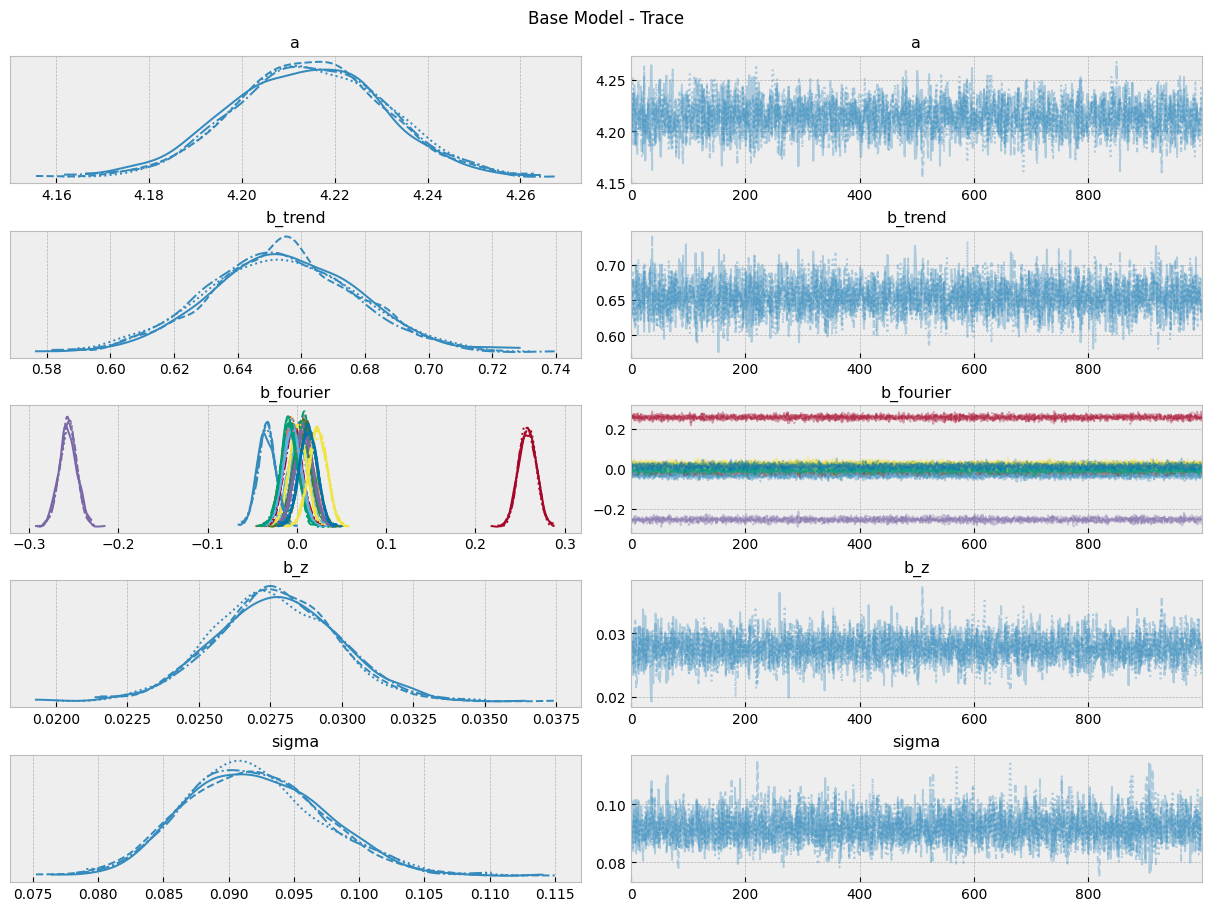

In [104]:
axes = az.plot_trace(
    data=base_model_trace,
    var_names=["~seasonality", "~trend" ,"~z_effect"],
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace");

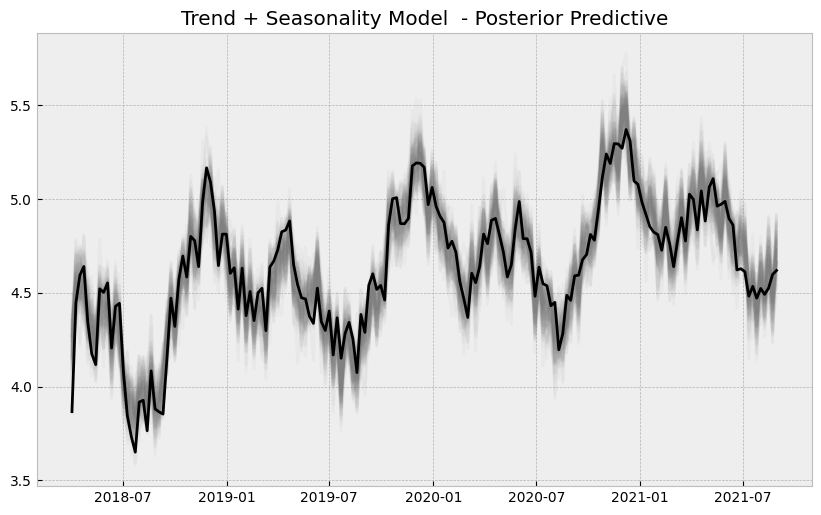

In [105]:
fig, ax = plt.subplots()
ax.plot(
    date,
    _sample(array=base_model_posterior_predictive["likelihood"], n_samples=100).T,
    color="gray",
    alpha=0.05,
)
sns.lineplot(x=date, y=y, color="black", ax=ax)
ax.set(title="Trend + Seasonality Model  - Posterior Predictive");

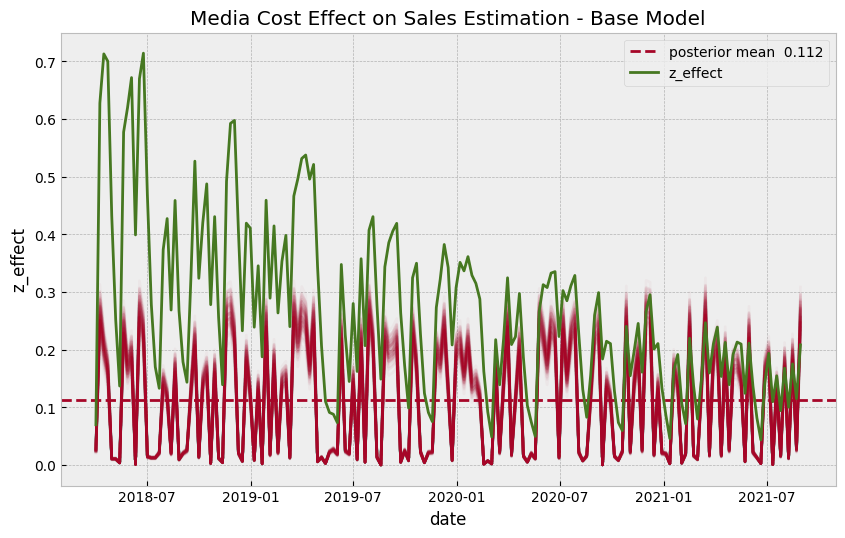

In [106]:
z_effect_posterior_samples = base_model_trace["posterior"]["z_effect"].stack(sample=("chain", "draw"))

fig, ax = plt.subplots()
ax.plot(
    date,
    _sample(array=z_effect_posterior_samples.T, n_samples=100).T,
    color="C1",
    alpha=0.03,
)
ax.axhline(
    y=z_effect_posterior_samples.mean(),
    color="C1",
    linestyle="--",
    label=f"posterior mean {z_effect_posterior_samples.mean().values: 0.3f}"
)
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, label="z_effect", ax=ax)
ax.set(title="Media Cost Effect on Sales Estimation - Base Model");

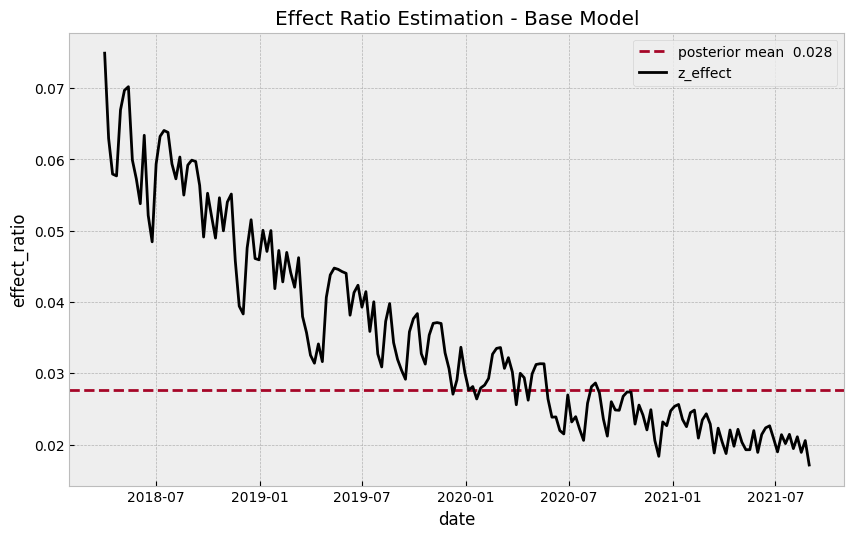

In [107]:
b_z_posterior_samples = base_model_trace["posterior"]["b_z"]

fig, ax = plt.subplots()
ax.axhline(
    y=b_z_posterior_samples.mean(),
    color="C1",
    linestyle="--",
    label=f"posterior mean {b_z_posterior_samples.mean().values: 0.3f}"
)
sns.lineplot(x="date", y="effect_ratio", color="black", data=data_df, label="z_effect", ax=ax)
ax.set(title="Effect Ratio Estimation - Base Model");